In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestRegressor

In [3]:
train_df = pd.read_csv("train.csv")
train_copy = train_df.copy()

In [4]:
train_copy.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
train_copy.drop('Id',axis=1,inplace=True)

In [7]:
train_copy.shape

(1460, 80)

In [8]:
train_copy.duplicated().sum()

0

checking null values column

In [9]:
train_copy.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

****Droping null values columns****

In [10]:
list_droping_column = []
for column in train_copy.columns:
    value = train_copy[column].isna().sum()
    if (value/1460)*100>10:
        list_droping_column.append(column)
        train_copy.drop(column,axis=1,inplace=True)

In [11]:
list_droping_column

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [12]:
train_copy.shape

(1460, 74)

In [13]:
train_copy = train_copy.dropna()

In [14]:
#list(train_copy.isna().sum())

In [15]:
num_col = []
for i in train_copy.columns:
    if train_copy[i].dtype != 'object':
        num_col.append(i)
cat_col = []
for i in train_copy.columns:
    if train_copy[i].dtype == 'object':
        cat_col.append(i)
        
print("num column =" , len(num_col))
print("cat column =" , len(cat_col))

num column = 36
cat column = 38


# ****Analysis of some numerical column in this dataset****

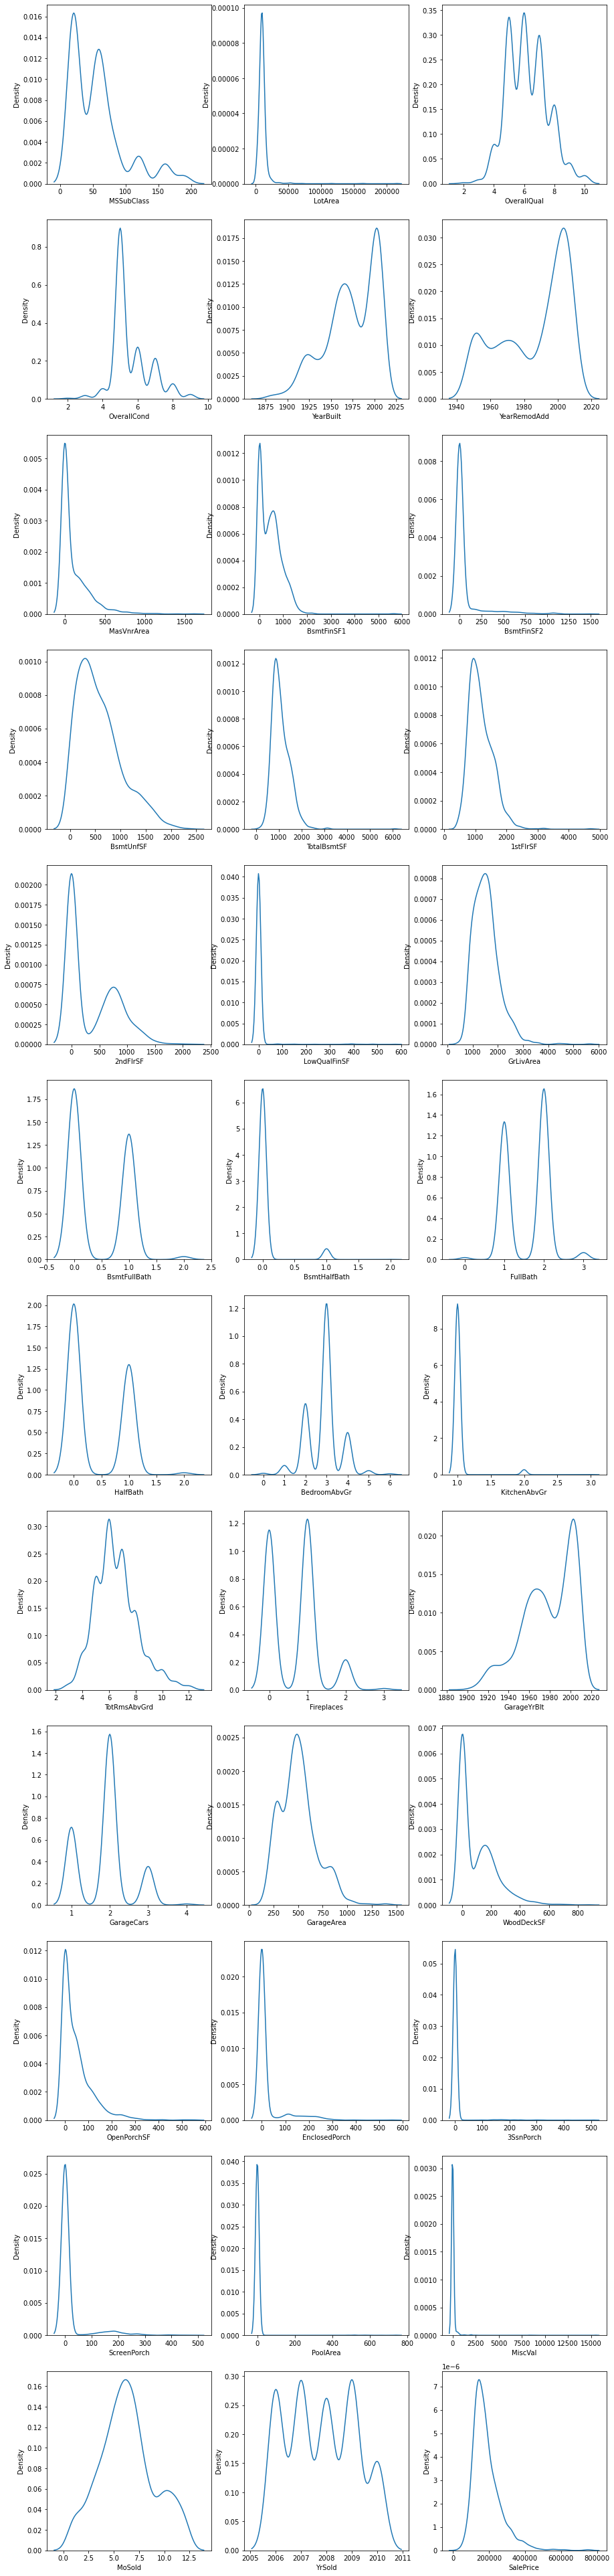

In [16]:
plt.figure(figsize=(15,70), facecolor='white')
plotnumber = 1

for i in num_col:
    if plotnumber<=74 :
        ax = plt.subplot(12,3,plotnumber)
        sns.kdeplot(train_copy[i])
    plotnumber+=1
plt.show()

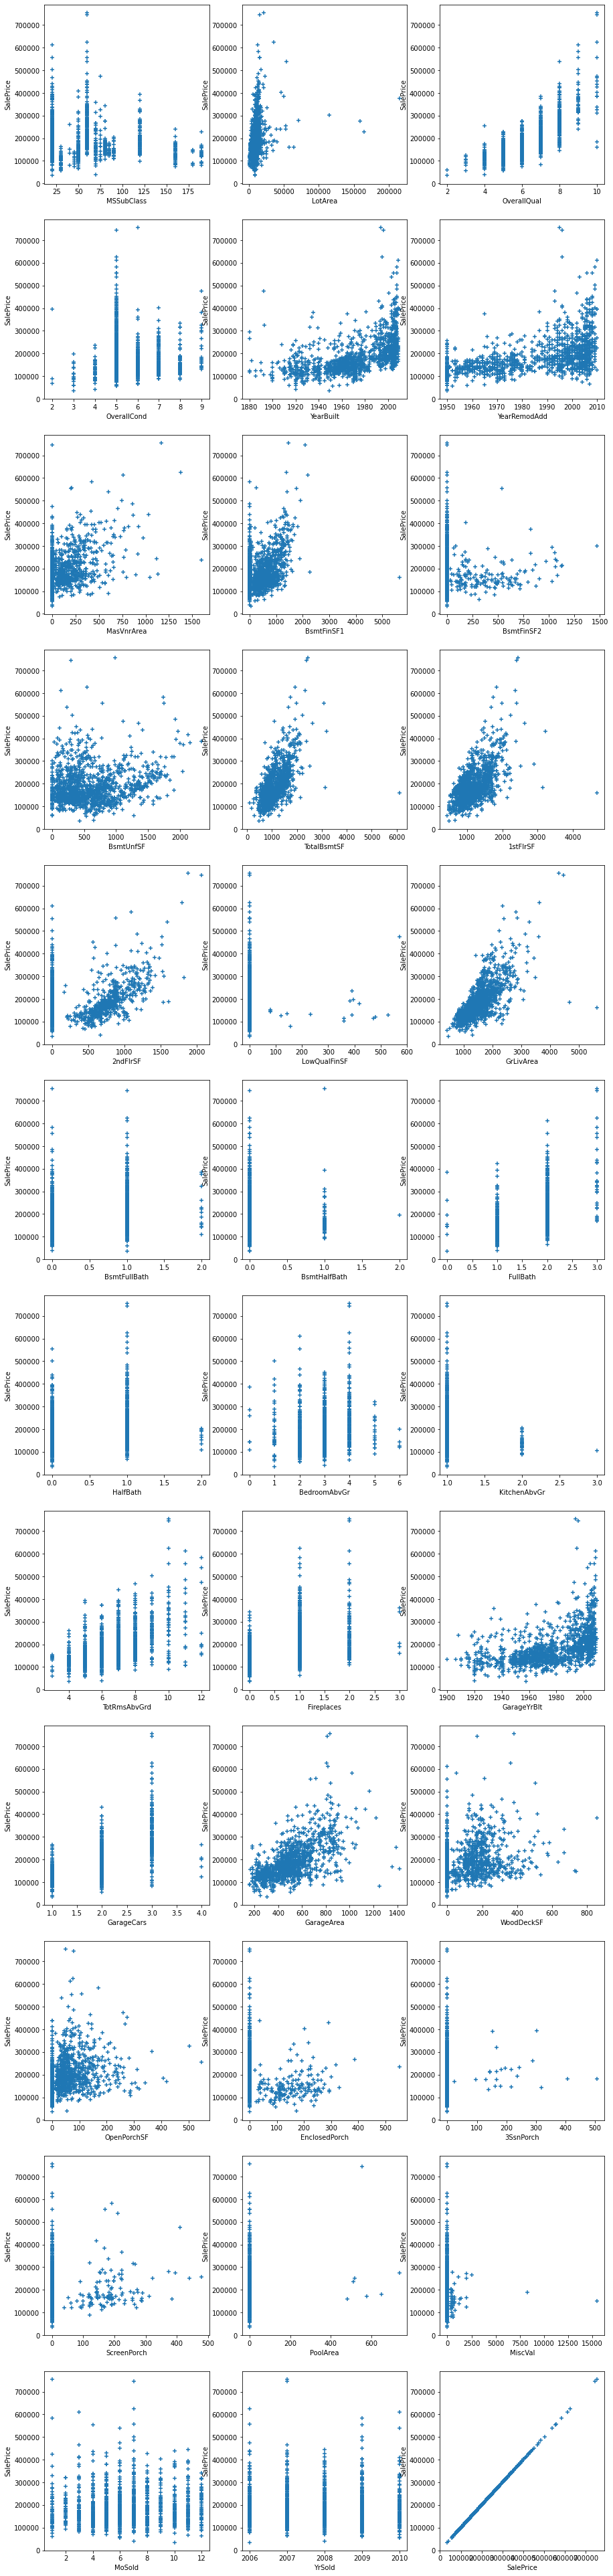

In [17]:
plt.figure(figsize=(15,70), facecolor='white')
plotnumber = 1

for i in num_col:
    if plotnumber<=36 :
        ax = plt.subplot(12,3,plotnumber)
        plt.scatter(train_copy[i],train_copy['SalePrice'],marker='+',)
        plt.xlabel(i)
        plt.ylabel('SalePrice',fontsize=10)
    plotnumber+=1
plt.show()

In [18]:
train_copy.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,...,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,56.136024,10706.294469,6.219731,5.596413,1973.029148,1985.668909,110.360239,464.234679,49.218236,582.494768,...,99.384903,47.782511,21.263827,3.585949,16.43423,3.010463,42.932735,6.331839,2007.805680,186761.782511
std,41.252576,10336.621126,1.324472,1.078124,29.563540,20.296463,185.604816,458.792420,166.196584,439.950528,...,127.537065,65.362562,60.843964,30.224622,58.05159,41.961337,508.056255,2.699437,1.330691,78913.847668
min,20.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,7744.000000,5.000000,5.000000,1956.000000,1968.000000,0.000000,0.000000,0.000000,248.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.000000,2007.000000,135000.000000
50%,50.000000,9600.000000,6.000000,5.000000,1976.000000,1994.500000,0.000000,413.000000,0.000000,489.000000,...,6.000000,28.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000,2008.000000,168500.000000
75%,70.000000,11760.750000,7.000000,6.000000,2001.000000,2004.000000,174.000000,733.000000,0.000000,815.750000,...,174.500000,70.000000,0.000000,0.000000,0.00000,0.000000,0.000000,8.000000,2009.000000,220000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.00000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [19]:
train_copy.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


****correlation between all numerical columns****

<AxesSubplot:>

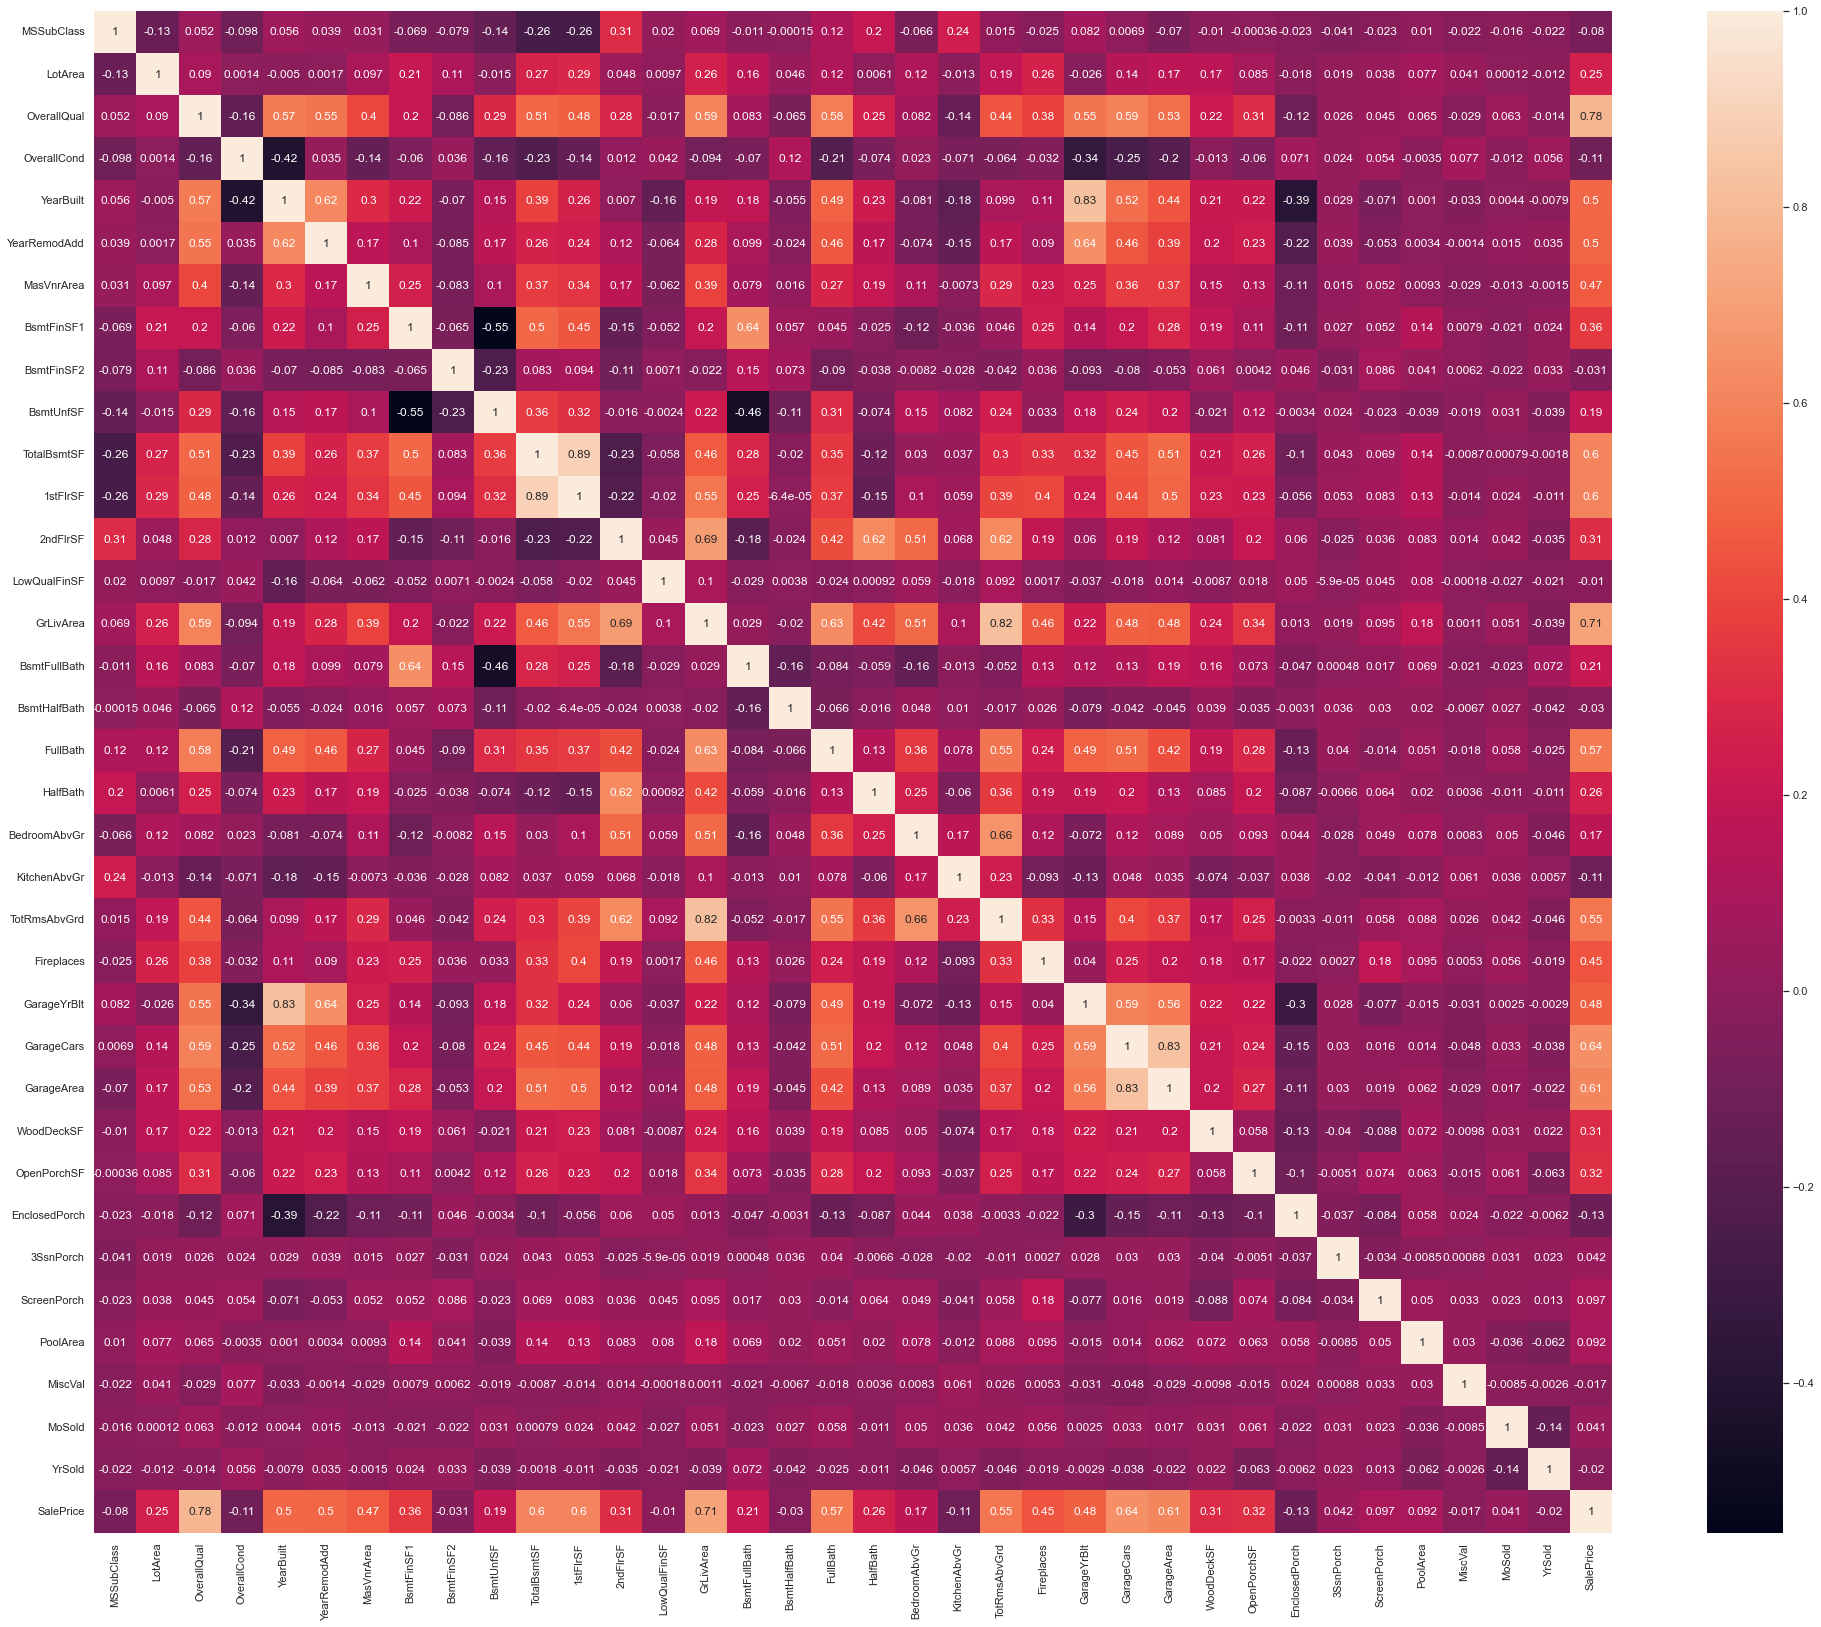

In [20]:
sns.set(rc={'figure.figsize':(34,28)})
sns.heatmap(train_copy[num_col].corr(),annot=True)

****Identifying the pattern between OverallQual class and SalePrice class****

Text(0.5, 0, 'OverallQual')

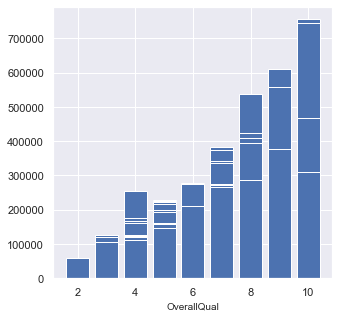

In [21]:
plt.figure(figsize=(5,5))
plt.bar(train_copy['OverallQual'], train_copy['SalePrice'])
plt.xlabel("OverallQual",fontsize=10)

In [22]:
#plt.figure(figsize=(5,5))
#plt.scatter(train_copy['OverallQual'],train_df['SalePrice'],marker='1',c='#6959CD')

Text(0.5, 0, 'OverallQual')

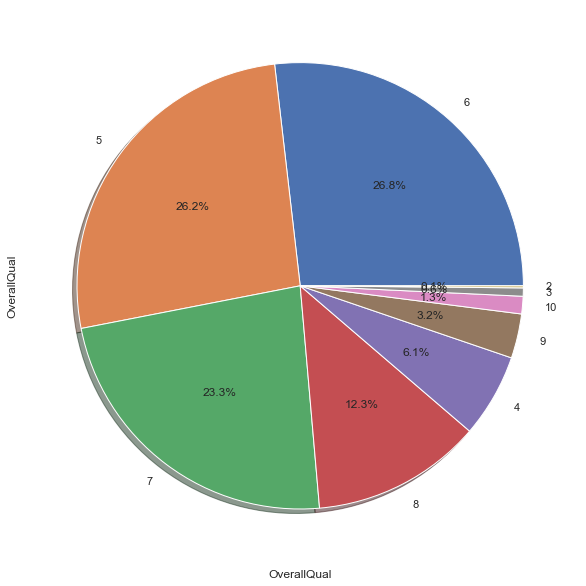

In [23]:
plt.figure(figsize=(10,15), facecolor='white')
train_copy['OverallQual'].value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,)
plt.xlabel("OverallQual")

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

* we can see a good correlation between these two classes.
* If OverallQual of house if increasing price also increase vice versa.
* 27.2 percent of house having average material and finish.
* 0.1 percent of house having Very Excellent material and finish.

****Identifying the pattern between built year and SalePrice****

Text(0.5, 0, 'YearBuilt')

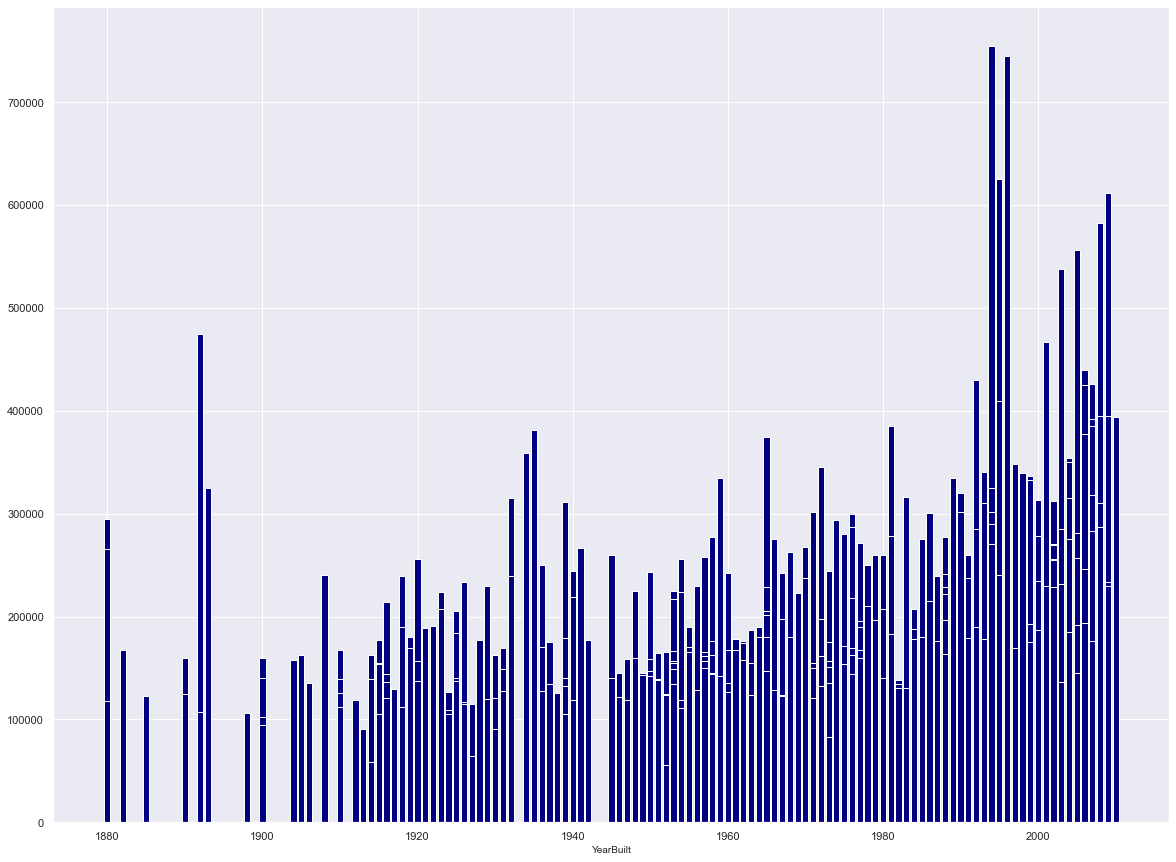

In [24]:
plt.figure(figsize=(20,15))
plt.bar(train_copy['YearBuilt'], train_copy['SalePrice'],color = "navy")
plt.xlabel("YearBuilt",fontsize=10)

Text(0.5, 0, 'YearBuilt')

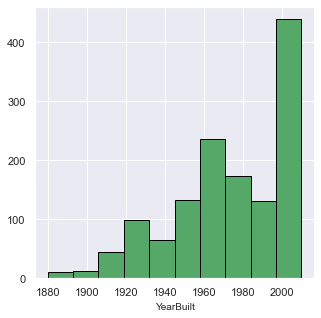

In [25]:
plt.figure(figsize=(5,5))
plt.hist(train_copy['YearBuilt'], ec = "black", color='g')
plt.xlabel("YearBuilt",fontsize=10)

* So we can see a gradually increament of SalePrice with increment of Year.
* so each and every year new new things introduce new types of material etc due to this we can see a gradually increament.
* From 2000 number of houses increase drastically.

****Analysing effect of Total square feet of basement area of house to SalePrice****

Text(0, 0.5, 'SalePrice')

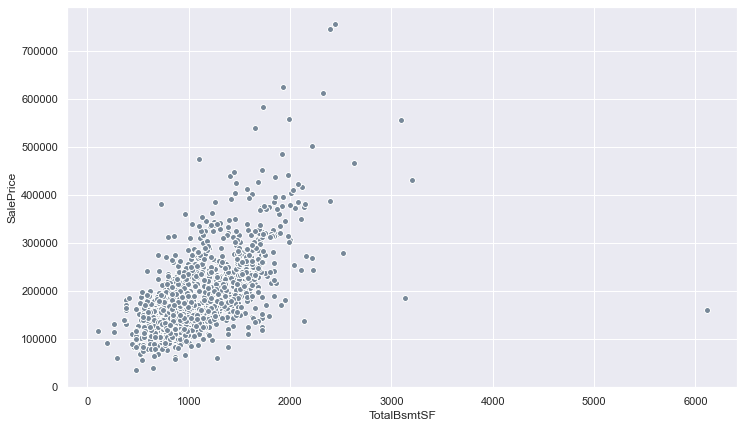

In [26]:
plt.figure(figsize=(12,7))
plt.scatter(train_copy['TotalBsmtSF'],train_copy['SalePrice'],ec = "white",c='#778899')
plt.xlabel("TotalBsmtSF")
plt.ylabel("SalePrice")

* So we can see a positive correlation between these two classes so this class can help our model to learn something

****Now Analyse GrLivArea class effect on SalePrice****

GrLivArea: Above grade (ground) living area square feet

Text(0, 0.5, 'SalePrice')

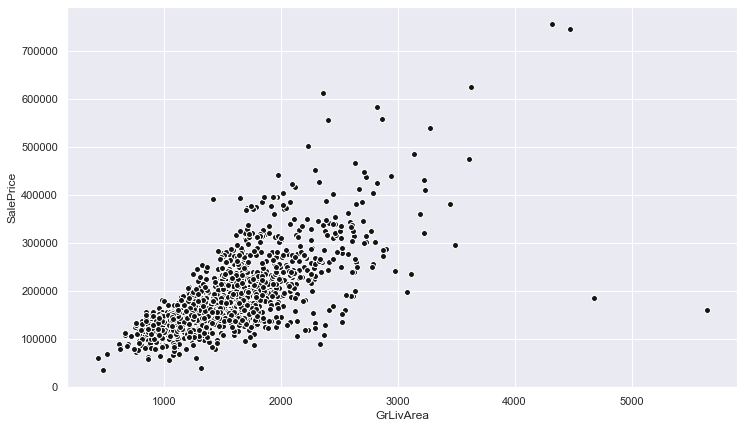

In [27]:
plt.figure(figsize=(12,7))
plt.scatter(train_copy['GrLivArea'],train_copy['SalePrice'],ec = "w",c='#141414')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

* we can see that GrLivArea is highly correlated with SalePrice so basically this column can help to learn our model.
* greater ground living area square feet greater the Price.

****Effect of FullBath class on SalePrice****

FullBath: Full bathrooms above grade.

Above grade:The different levels of the home are often referred to as "Grade Levels." For example, in most cases, when you walk into a home through the front door, that ground level floor is known as "on grade." Every floor located above this ground level on grade is considered to be "above grade."

Text(0.5, 0, 'FullBath')

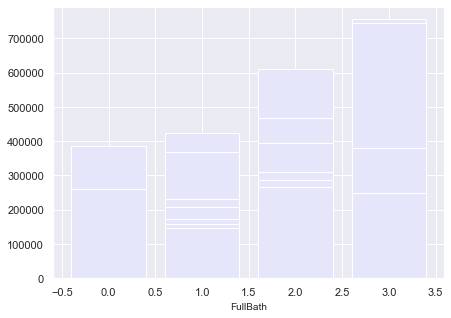

In [28]:
plt.figure(figsize=(7,5))
plt.bar(train_copy['FullBath'], train_copy['SalePrice'],color = "#E6E6FA")
plt.xlabel("FullBath",fontsize=10)

Text(0.5, 0, 'FullBath')

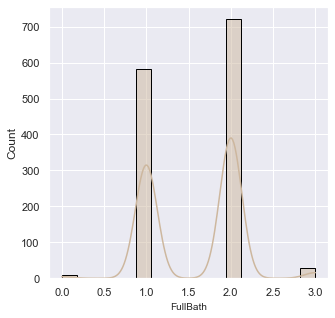

In [29]:
plt.figure(figsize=(5,5))
sns.histplot(train_copy['FullBath'],kde=True, ec = "black", color='#CDB79E')
plt.xlabel("FullBath",fontsize=10)

Text(0.5, 0, 'FullBath')

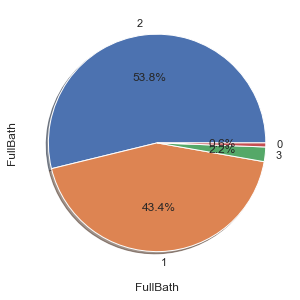

In [30]:
plt.figure(figsize=(5,5), facecolor='white')
train_copy['FullBath'].value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,)
plt.xlabel("FullBath")

* so we can conclude that full bath column have some effect on Sale Price column.
* if any house have 2 full bath than it is little bit expensive then the house have 1 or less then 1 full bath.
* 52.6 percent of house having 1 bath.
* 44.5 percent of house having 2 bath.
* little bit price increase if a house have 2 or more bath.

****Analysing effect of total room on Sale price class****

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Text(0.5, 0, 'TotRmsAbvGrd')

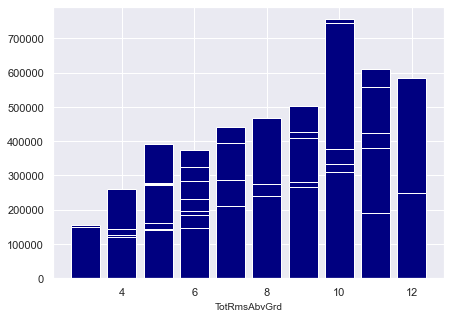

In [31]:
plt.figure(figsize=(7,5))
plt.bar(train_copy['TotRmsAbvGrd'], train_copy['SalePrice'],color = "navy")
plt.xlabel("TotRmsAbvGrd",fontsize=10)

Text(0.5, 0, 'TotRmsAbvGrd')

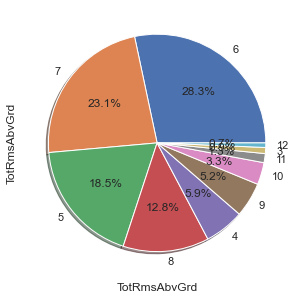

In [32]:
plt.figure(figsize=(5,5), facecolor='white')
train_copy['TotRmsAbvGrd'].value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,)
plt.xlabel("TotRmsAbvGrd")

* so we have many outlier in this class we have to treat them.
* yes some correlation we can see but not that much high.

****GarageArea effect on SalePrice****

GarageArea: Size of garage in square feet

Text(0, 0.5, 'SalePrice')

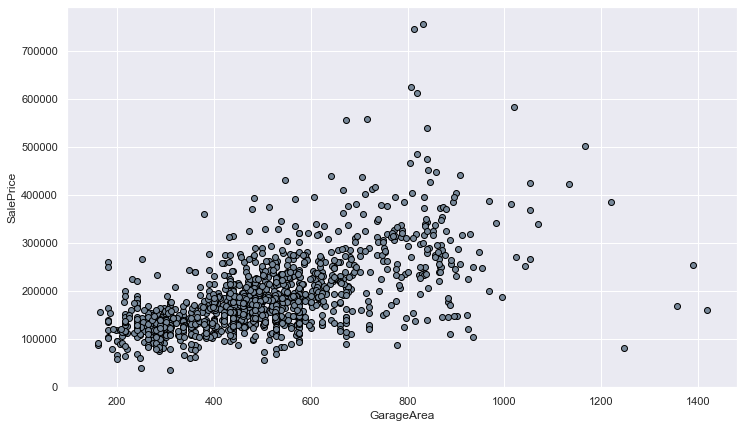

In [33]:
plt.figure(figsize=(12,7))
plt.scatter(train_copy['GarageArea'],train_copy['SalePrice'],ec = "black",c='#778899')
plt.xlabel("GarageArea")
plt.ylabel("SalePrice")

In [34]:
train_copy['GarageArea'].mean()

501.44992526158444

In [35]:
train_copy['GarageArea'].max()

1418

* we concude that GarageArea have good correlation with Sale Price class.
* grerater the area greter the price.
* Average area of house in this dataset approx 472 and max near 1418.

****------------------------------------------------------------------------------------------------------------------------------------------------------------------------------****

# ****Analysis of some categorical columns****

In [36]:
#f = open("/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt", "r")
#print(f.read())

In [37]:
train_copy[cat_col].describe().T

,count,unique,top,freq
MSZoning,1338,5,RL,1066
Street,1338,2,Pave,1333
LotShape,1338,4,Reg,829
LandContour,1338,4,Lvl,1206
Utilities,1338,2,AllPub,1337
LotConfig,1338,5,Inside,957
LandSlope,1338,3,Gtl,1265
Neighborhood,1338,25,NAmes,209
Condition1,1338,9,Norm,1162
Condition2,1338,8,Norm,1324


# ****Check collinearity for Categorical features****

- A chi-squared test (also chi-square or χ2 test) is a statistical hypothesis test that is valid to perform when the test statistic is chi-squared distributed under the null hypothesis, specifically Pearson's chi-squared test**

- A chi-square statistic is one way to show a relationship between two categorical variables.**

- Here we test correlation of Categorical columns with Target column i.e Selling Price**

In [38]:
from scipy.stats import chi2_contingency
chi2_test = []
for feature in train_copy[cat_col]:
    if chi2_contingency(pd.crosstab(train_copy['SalePrice'], train_copy[feature]))[1] < 0.05:
        chi2_test.append('Reject Null Hypothesis')
    else:
        chi2_test.append('Fail to Reject Null Hypothesis')
result = pd.DataFrame(data=[cat_col, chi2_test]).T
result.columns = ['Column', 'Hypothesis Result']
result

,Column,Hypothesis Result
0,MSZoning,Reject Null Hypothesis
1,Street,Reject Null Hypothesis
2,LotShape,Reject Null Hypothesis
3,LandContour,Fail to Reject Null Hypothesis
4,Utilities,Fail to Reject Null Hypothesis
5,LotConfig,Fail to Reject Null Hypothesis
6,LandSlope,Fail to Reject Null Hypothesis
7,Neighborhood,Reject Null Hypothesis
8,Condition1,Fail to Reject Null Hypothesis
9,Condition2,Reject Null Hypothesis


****Identifing the pattern between MSZoning class and SalePrice class****

C(all)	Commercial,Agriculture,Industrial,

FV	Floating Village Residential,

RH	Residential High Density,

RL	Residential Low Density,

RM	Residential Medium Density,

(-1.0, 5.0)

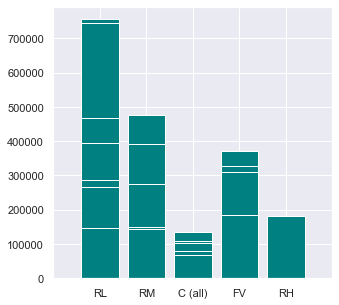

In [39]:
plt.figure(figsize=(5,5), facecolor='white')
plt.bar(train_copy['MSZoning'], train_copy['SalePrice'], color = "#008080")
plt.xlim(-1,5)

* So, House price in residential low density area are most expenisve.
* people prefer to purchase house in low density area.

****Analysis LotShape class****

LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

Text(0, 0.5, 'SalePrice')

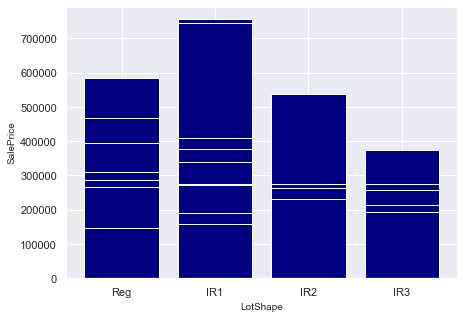

In [40]:
plt.figure(figsize=(7,5))
plt.bar(train_copy['LotShape'], train_copy['SalePrice'],color = "navy")
plt.xlabel("LotShape",fontsize=10)
plt.ylabel("SalePrice",fontsize=10)

Text(0, 0.5, 'SalePrice')

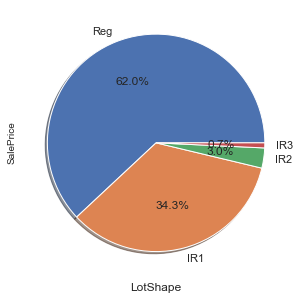

In [41]:
plt.figure(figsize=(5,5), facecolor='white')
train_copy['LotShape'].value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,)
plt.xlabel("LotShape")
plt.ylabel("SalePrice",fontsize=10)

* so generally people prefer regular shape of house.
* Here almost 63.4 percent of people bought regular shape of house.

****Is there any effect on Sale Price due to street type of house lets see****

Street: Type of road access to property

    Grvl - Gravel	
    Pave - Paved

Text(0, 0.5, 'SalePrice')

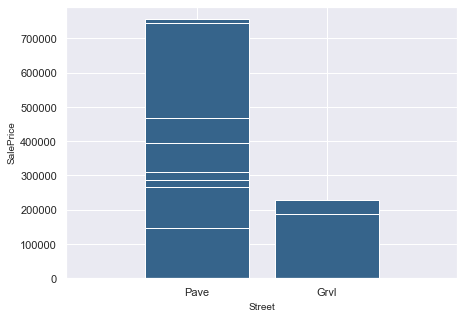

In [42]:
plt.figure(figsize=(7,5))
plt.bar(train_copy['Street'], train_copy['SalePrice'],color = "#36648B")
plt.xlabel("Street",fontsize=10)
plt.xlim(-1,2)
plt.ylabel("SalePrice",fontsize=10)

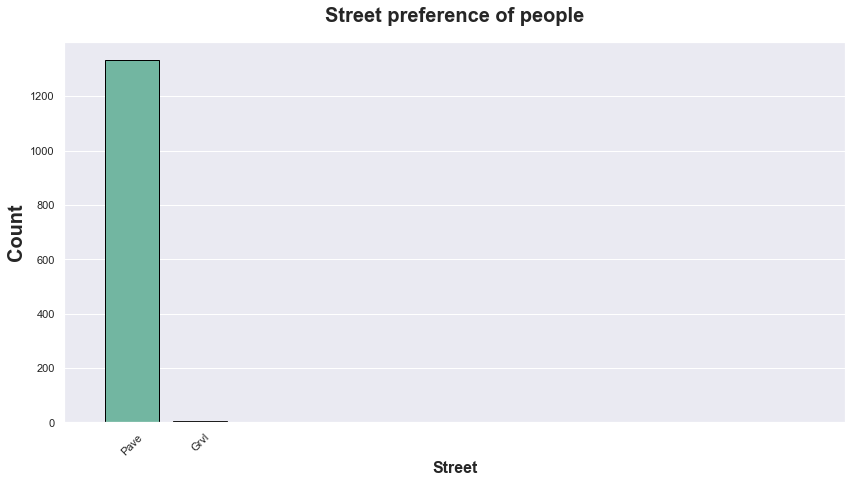

In [43]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Street", data=train_copy,ec = "black",palette="Set2",order = train_copy['Street'].value_counts().index)
plt.title("Street preference of people", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("Street", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

# * This can be a important factor while purchasing a house every one want the street of house should be paved.
* Yes there is some impact of street class on Sale Price class.
* Almost 99 percent people prefer paved road in this dataset.

****Now we analysis which type of neighborhood people prefer generally****

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

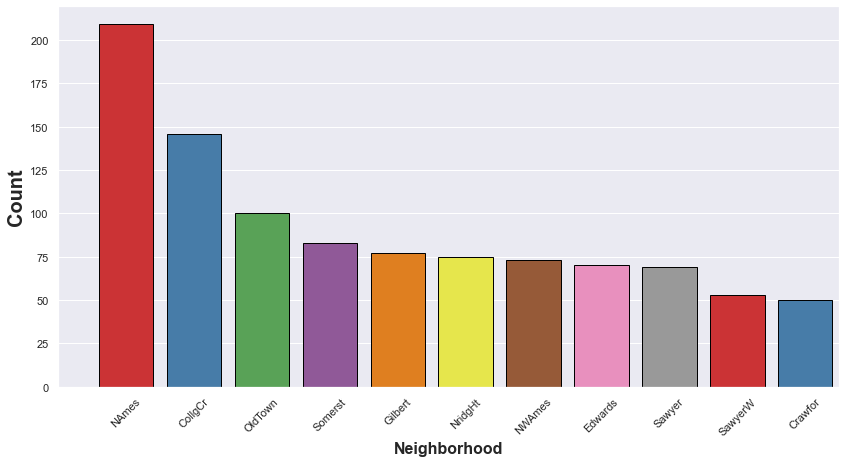

In [44]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Neighborhood", data=train_copy,ec = "black",palette="Set1",order = train_copy['Neighborhood'].value_counts().index)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("Neighborhood", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

Text(0, 0.5, 'SalePrice')

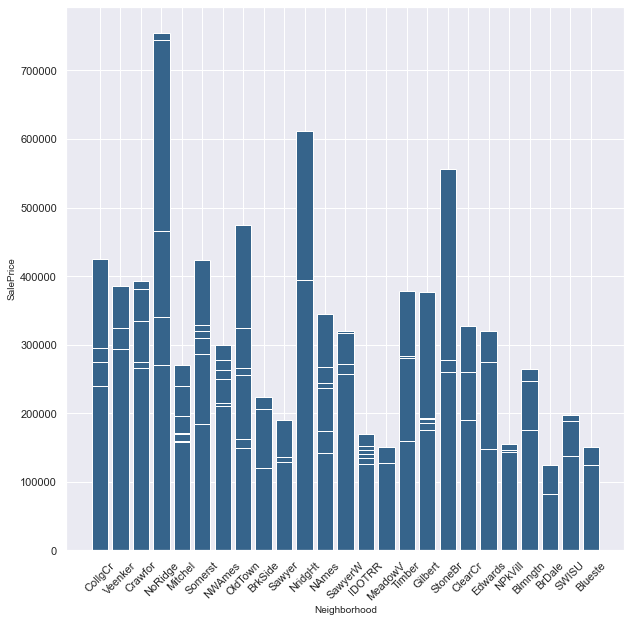

In [45]:
plt.figure(figsize=(10,10))
plt.bar(train_copy['Neighborhood'], train_copy['SalePrice'],color = "#36648B")
plt.xlabel("Neighborhood",fontsize=10)
plt.xticks(rotation= 45)
plt.ylabel("SalePrice",fontsize=10)

* So, people prefer neighborhood as Northwest Ames accroding to this analysis.
* Most expensive house are near Northridge.
* people less prefer house near Brookside.

****Let's analysis Sale type class****

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

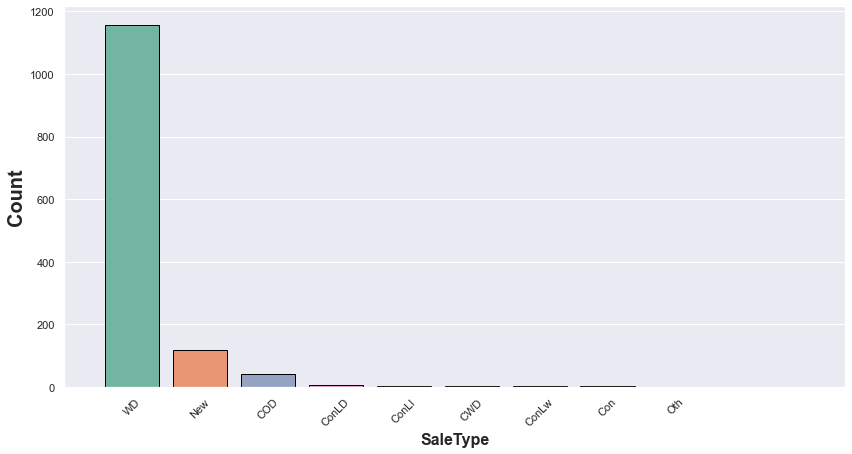

In [46]:
plt.subplots(figsize=(14,7))
sns.countplot(x="SaleType", data=train_copy,ec = "black",palette="Set2",order = train_copy['SaleType'].value_counts().index)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("SaleType", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

In [47]:
list_of_per = []
for i in train_copy['SaleType'].value_counts():
    perc = i/train_copy['SaleType'].value_counts().sum()*100
    list_of_per.append(perc)
Saletype_data = (pd.DataFrame(list_of_per,train_copy['SaleType'].value_counts().index))
Saletype_data.columns = ['percentage']
Saletype_data

,percentage
WD,86.547085
New,8.744395
COD,3.139013
ConLD,0.448430
ConLI,0.298954
CWD,0.298954
ConLw,0.298954
Con,0.149477
Oth,0.074738


* Warranty Deed : A warranty deed is a document sometimes used in real estate, which offers the buyer of property the greatest amount of insurance. It guarantees or warrants that the property is owned by the owner free of any unpaid liens, mortgages, or other obligations against it

* So more than 86.78 percent people prefer sale type of a house as warranty deed.

****Lets convert categorical column to numerical so that we can analysis and make a tranform object for test data****

In [48]:
#converting categorical data to numerical data and save that ordinal encoder object in encoder_object object
encoder_object = OrdinalEncoder()
cat_data = train_copy[cat_col]
data_encoded = encoder_object.fit_transform(cat_data)
cat_data = pd.DataFrame(data_encoded,columns=cat_col)
if 'Id' in cat_data.columns:
    cat_data = cat_data.drop('Id',axis=1)

<AxesSubplot:>

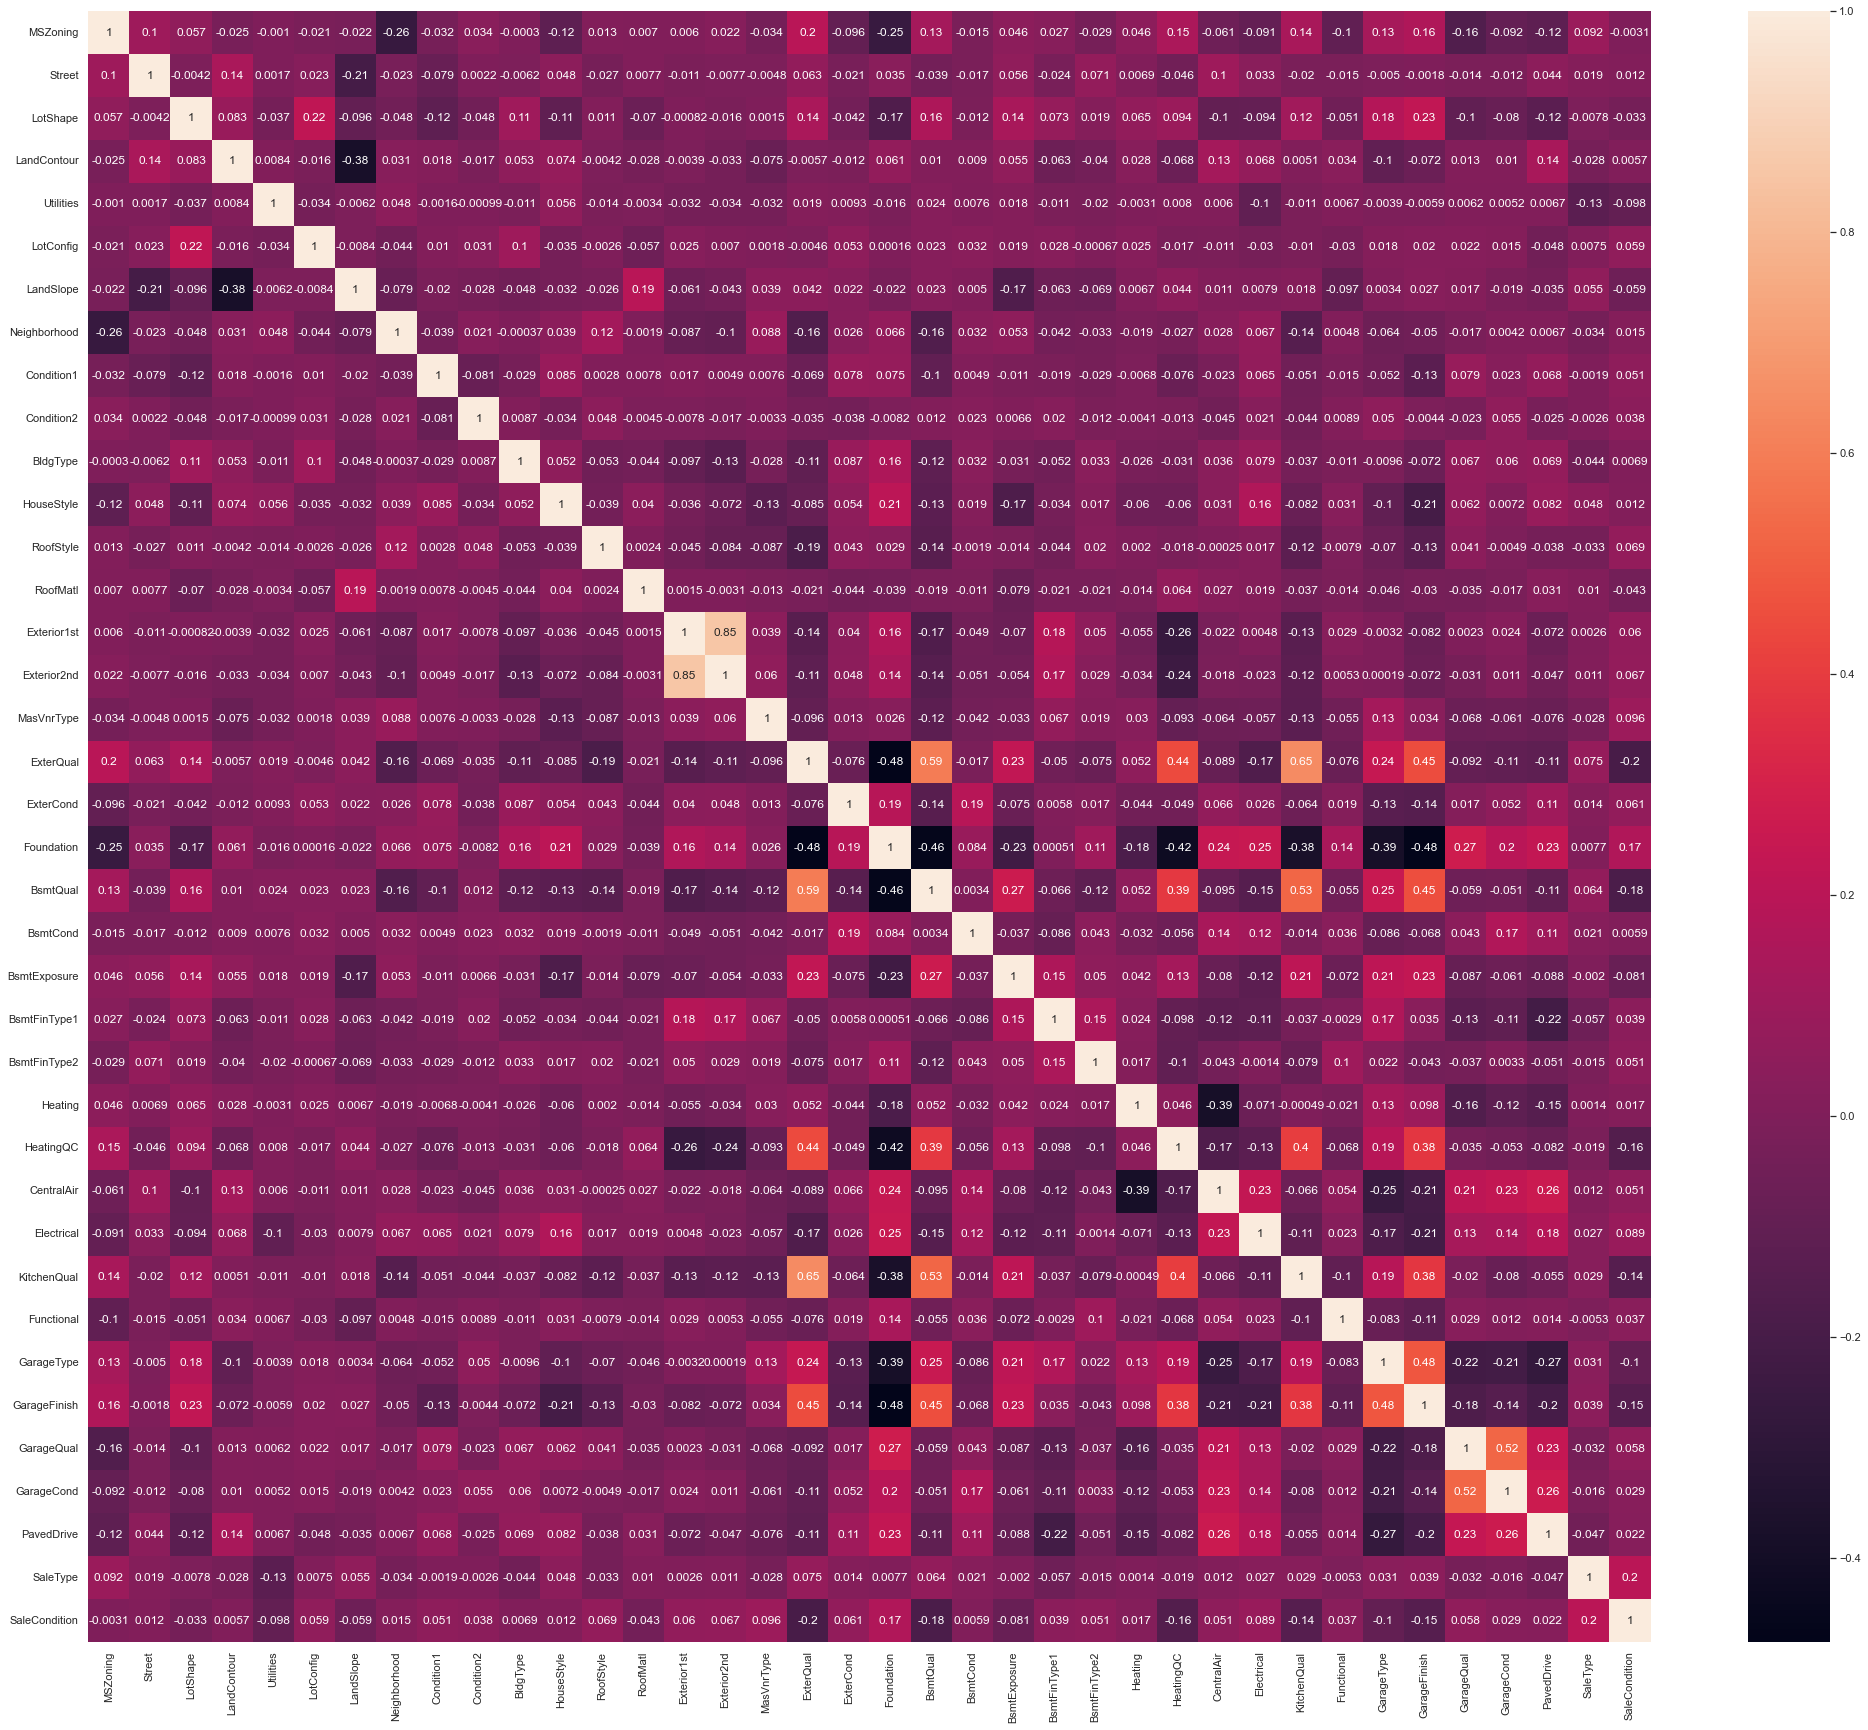

In [49]:
sns.set(rc={'figure.figsize':(35,30)})
sns.heatmap(cat_data.corr(),annot=True)

In [50]:
cat_data.head(4)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,3.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,3.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,...,4.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,3.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,3.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,...,4.0,2.0,6.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0


In [51]:
num_data = train_copy[num_col]
if 'Id' in num_data.columns:
    num_data = num_data.drop('Id',axis=1)
num_data.head(4)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,7,5,2003,2003,196.0,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,6,8,1976,1976,0.0,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,7,5,2001,2002,162.0,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,7,5,1915,1970,0.0,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000


In [52]:
#merging both dataframe to single dataframe
train_data = pd.concat([cat_data,num_data],axis=1)#train data
if 'Id' in train_data.columns:
    train_data = train_data.drop('Id',axis=1)


In [53]:
train_data = train_data.dropna()

In [54]:
train_data.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,3.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,3.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,3.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,3.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,3.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


****Some classes are imbalance in this dataset****

Handling an imbalanced class in a dataset is an important task in machine learning. An imbalanced dataset occurs when one class has significantly more or fewer samples than the others. This can lead to the machine learning algorithm being biased towards the majority class and not being able to accurately predict the minority class. There are several techniques that can be used to handle imbalanced classes:

1. Resampling: One way to handle imbalanced classes is to resample the dataset. This can be done in two ways: undersampling and oversampling. Undersampling involves reducing the size of the majority class, while oversampling involves increasing the size of the minority class. The goal of resampling is to balance the number of samples in each class.

2. Use ensemble models: Another way to handle imbalanced classes is to use ensemble models such as Random Forest or Gradient Boosting. These models combine the predictions of multiple weaker models to make more accurate predictions.

#### Checking for outliers and removing

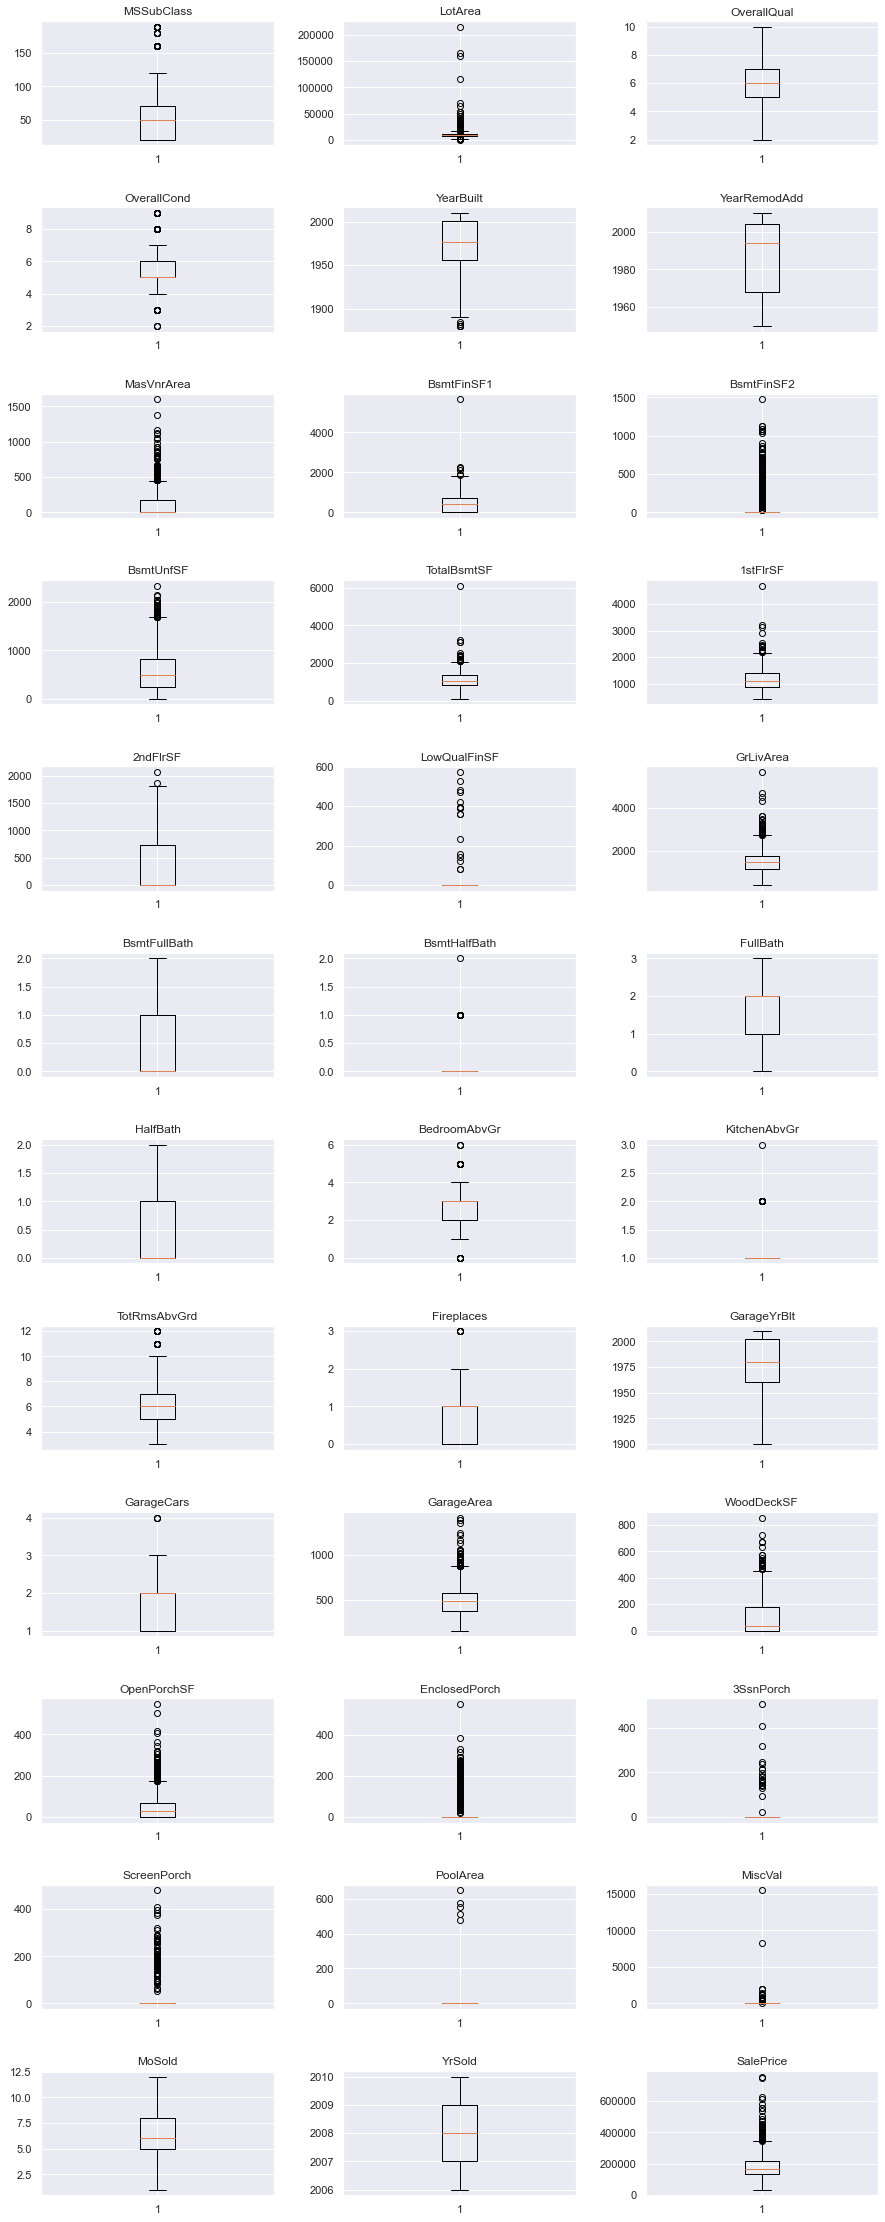

In [55]:
fig, axs = plt.subplots(nrows=12, ncols=3, figsize=(15, 40))

# Flatten the subplot grid for easy iteration
axs = axs.ravel()

# Plot boxplots for each column in the dataframe
for i, col in enumerate(num_col):
    axs[i].boxplot(train_data[col])
    axs[i].set_title(col)

# Adjust the subplot spacing
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Show the plot
plt.show()

#### Treating Outliers

In [56]:
# Function to detect outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


## function to remove outliers
def replace_with_thresholds(dataframe,columns):
    for col in columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        dataframe.loc[(dataframe[col] < low_limit), col] = low_limit
        dataframe.loc[(dataframe[col] > up_limit), col] = up_limit

In [57]:
replace_with_thresholds(train_data,num_col)

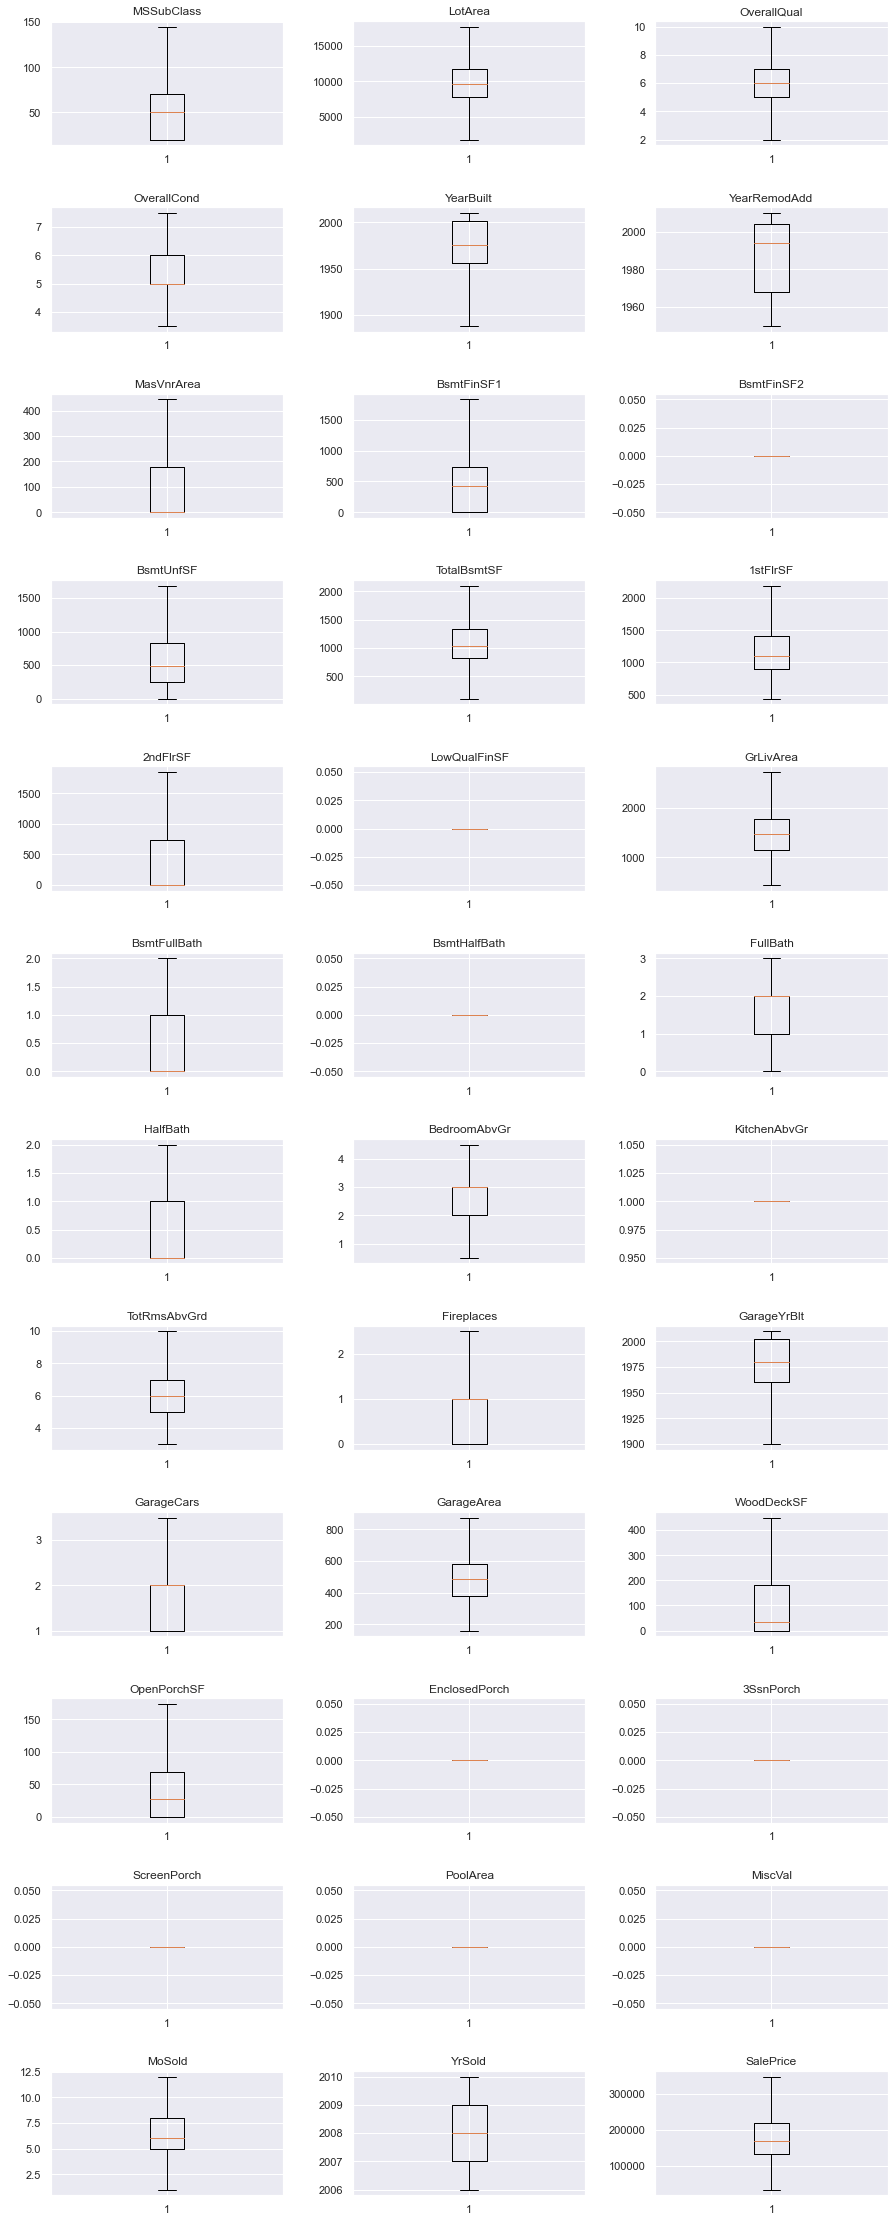

In [58]:
fig, axs = plt.subplots(nrows=12, ncols=3, figsize=(15, 40))

# Flatten the subplot grid for easy iteration
axs = axs.ravel()

# Plot boxplots for each column in the dataframe
for i, col in enumerate(num_col):
    axs[i].boxplot(train_data[col])
    axs[i].set_title(col)

# Adjust the subplot spacing
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Show the plot
plt.show()

In [59]:
X = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]

#### Spliting dataset

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [61]:
re_model = RandomForestRegressor(random_state=7)
re_model.fit(X_train, y_train)

RandomForestRegressor(random_state=7)

In [62]:
#prediction

In [63]:
y_pred = re_model.predict(X_test)

In [64]:
#score of test

In [65]:
r2_score(y_pred,y_test)

0.8563876700037432

In [66]:
#hyperparameter tunning

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [68]:
grid_param = {
    "n_estimators" : [90,100],
    'max_depth' : range(1,7,1),
    'min_samples_leaf' : range(1,7,1),
    'min_samples_split': range(1,7,1),
    'max_features' : ['auto','log2']
}

In [69]:
rf_model_hyp= RandomizedSearchCV(re_model,grid_param)

In [70]:
rf_model_hyp.fit(X_train,y_train)

C:\Users\bhupe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bhupe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bhupe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\bhupe\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\bhupe\anaconda3\lib\site-packages\jo

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=7),
                   param_distributions={'max_depth': range(1, 7),
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': range(1, 7),
                                        'min_samples_split': range(1, 7),
                                        'n_estimators': [90, 100]})

In [71]:
rf_model_hyp.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 6}

In [72]:
re_best_model = RandomForestRegressor(n_estimators= 100, min_samples_split= 6, min_samples_leaf= 6,
                                      max_features= 'auto',
                                       max_depth= 5,random_state=7)

In [73]:
re_best_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=6,
                      random_state=7)

In [74]:
y_pred_new = re_best_model.predict(X_test)

In [75]:
r2_score(y_test,y_pred_new)

0.8425685769781586

# Prediction of Test data

In [76]:
test_data = pd.read_csv("test.csv")

In [77]:
id_list = list(test_data['Id'])
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**Droping some columns according to our analysis**

In [78]:
test_data.drop('Id',axis=1,inplace=True)
test_data = test_data.drop(list_droping_column,axis=1)

In [79]:
# categorical column and numerical column
num_test_col = []
for i in test_data.columns:
    if test_data[i].dtype != 'object':
        num_test_col.append(i)
cat_test_col = []
for i in test_data.columns:
    if test_data[i].dtype == 'object':
        cat_test_col.append(i)
        
print("num test column =" , len(num_test_col))
print("cat test column =" , len(cat_test_col))

num test column = 35
cat test column = 38


In [80]:
#removing some noise
def replace_noise(dataframe,columns):
    for col in columns:
        dataframe.loc[(dataframe[col] =='Po'), col]=test_data['GarageQual'].mode()
replace_noise(test_data,test_data.columns)

**converting categorical column to numerical with the help of ordinal encoder object**

In [81]:
test_data = test_data.dropna()
cat_data = encoder_object.transform(test_data[cat_test_col])
cat_data = pd.DataFrame(cat_data,columns=cat_test_col)
if 'Id' in cat_data.columns:
    cat_data = cat_data.drop('Id',axis=1)
cat_data.head(4)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,1.0,2.0,...,4.0,3.0,6.0,1.0,2.0,4.0,4.0,2.0,8.0,4.0
1,3.0,1.0,0.0,3.0,0.0,0.0,0.0,12.0,2.0,2.0,...,4.0,2.0,6.0,1.0,2.0,4.0,4.0,2.0,8.0,4.0
2,3.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,...,4.0,3.0,6.0,1.0,0.0,4.0,4.0,2.0,8.0,4.0
3,3.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,...,4.0,2.0,6.0,1.0,0.0,4.0,4.0,2.0,8.0,4.0


In [82]:
num_data = test_data[num_test_col]
if 'Id' in num_data.columns:
    num_data = num_data.drop('Id',axis=1)
num_data.head(4)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,20,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,60,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,60,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,...,470.0,360,36,0,0,0,0,0,6,2010


In [83]:
test_data = pd.concat([cat_data,num_data],axis=1)
if 'Id' in test_data.columns:
    train_data = train_data.drop('Id',axis=1)

In [84]:
test_data = test_data.dropna()

In [85]:
model_prediction = re_model.predict(test_data)

In [86]:
decode = encoder_object.inverse_transform(cat_data)
decode_df = pd.DataFrame(decode,columns=[cat_test_col])

In [87]:
test_final = pd.concat([decode_df,num_data],axis=1)
test_final = test_final.dropna()

In [88]:
test_final['Prediction']=model_prediction

In [89]:
test_final.sample(20)

,"(MSZoning,)","(Street,)","(LotShape,)","(LandContour,)","(Utilities,)","(LotConfig,)","(LandSlope,)","(Neighborhood,)","(Condition1,)","(Condition2,)",...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Prediction
850,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,136,36,0,0,0,0,0,3,2007,217040.95
226,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,...,100,0,0,0,0,0,0,8,2009,169356.10
289,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,0,0,0,0,0,0,0,8,2009,151565.93
490,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,200,0,0,0,0,0,0,8,2008,295055.08
747,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,...,0,96,0,0,0,0,0,4,2008,231508.45
789,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,...,0,0,0,0,0,0,0,4,2008,140720.35
117,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,...,0,59,0,0,0,0,0,3,2010,151453.29
302,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,...,85,0,0,0,0,0,0,9,2009,163415.00
782,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,92,26,0,0,0,0,0,5,2008,137869.37
369,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,150,0,0,0,0,6,2009,141701.05


In [90]:
test_final.to_csv("submit.csv",index=False)